In [1]:
import mne
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import joblib
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pywt
from sklearn.decomposition import PCA

# Data direction
data_dir = 'data_competition/total'

In [2]:
labels_df = pd.read_csv(os.path.join(data_dir,'filtered_subjects_with_age.tsv'), sep='\t')

# Rename participant_id to subject
labels_df = labels_df.rename(columns={'participant_id':'subject'})

# Remove 'sub-' prefix from subject column
labels_df['subject'] = labels_df['subject'].str.replace('sub-', '', regex=False)

# Checking
print(labels_df)

      subject  age
0    CC110033   24
1    CC110037   18
2    CC110045   24
3    CC110056   22
4    CC110069   28
..        ...  ...
155  CC721704   82
156  CC721891   83
157  CC721894   80
158  CC722542   79
159  CC723395   86

[160 rows x 2 columns]


In [3]:
def extract_band_power_features(data, sfreq, n_fft=2048, n_overlap=1024):
    """
    Extract band power features from EEG data
    Args:
        data (np.ndarray): EEG data (channels x time).
        sfreq (float): Sampling frequency.
        n_fft (int): Number of FFT points
        n_overlap (int): Number of points for the overlap

    Returns:
        np.ndarray: Band power features (channels x bands).
    """
    freqs, psd = welch(data, sfreq, nperseg=n_fft, noverlap=n_overlap, axis=0, return_onesided=True)
    
    band_ranges = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    band_powers = []
    for band, (low, high) in band_ranges.items():
        freq_mask = (freqs >= low) & (freqs <= high)
        band_power = np.sum(psd[freq_mask])
        band_powers.append(band_power)
    return np.array(band_powers)

# Function to load EEG data from a single .fif file and extract features
def load_eeg_data_and_extract_features(file_path, feature_type="PSD", feature_dim=200):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    misc_channels = raw.copy().pick_types(misc=True)
    data = misc_channels.get_data()
    sfreq = raw.info['sfreq']
    band_features = []
    for channel in data:
        features = extract_band_power_features(channel, sfreq)
        band_features.append(features)
    features = np.array(band_features).flatten()

    return features

# Function to get the subject ID from file name
def get_subject_id(file_name):
    return file_name.split('-')[1].split('_')[0]

In [4]:
# Load all data
all_features_band = []
all_subjects = []
for filename in os.listdir(data_dir):
    if filename.endswith('.fif'):
        file_path = os.path.join(data_dir, filename)
        features_band = load_eeg_data_and_extract_features(file_path, feature_type="band")
        subject_id = get_subject_id(filename)
        
        all_features_band.append(features_band)
        all_subjects.append(subject_id)
        
all_features_band = np.array(all_features_band)
all_subjects = np.array(all_subjects)

# Convert into df
features_df_band = pd.DataFrame({'subject': all_subjects, 'features': list(all_features_band)})

print("features_df_band head:")
print(features_df_band.head())

# Merge with labels dataframe
merged_df_band = pd.merge(features_df_band, labels_df, on='subject')

Opening raw data file data_competition/total\sub-CC110033_sflip_parc-raw.fif...
    Range : 16750 ... 160249 =     67.000 ...   640.996 secs
Ready.
Reading 0 ... 143499  =      0.000 ...   573.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data_competition/total\sub-CC110037_sflip_parc-raw.fif...
    Range : 5000 ... 145499 =     20.000 ...   581.996 secs
Ready.
Reading 0 ... 140499  =      0.000 ...   561.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data_competition/total\sub-CC110045_sflip_parc-raw.fif...
    Range : 24000 ... 164499 =     96.000 ...   657.996 secs
Ready.
Reading 0 ... 140499  =      0.000 ...   561.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data_competition/total\sub-CC110056_sflip_parc-raw.fif...
    Range : 3750 ... 143999 =     15.000 ...   575.996 secs
Ready.
Reading 

In [10]:
# Prepare train and test dataset for BandPower
subjects_band = merged_df_band['subject'].tolist()
labels_band = merged_df_band['age'].tolist()
features_band = np.array(merged_df_band['features'].tolist())

# Randomly select 40 subjects for testing (BandPower)
np.random.seed(42)
test_size = 40
test_indices_band = np.random.choice(len(subjects_band), test_size, replace=False)

train_indices_band = [i for i in range(len(subjects_band)) if i not in test_indices_band]

X_train_band = features_band[train_indices_band]
y_train_band = np.array(labels_band)[train_indices_band]
X_test_band = features_band[test_indices_band]
y_test_band = np.array(labels_band)[test_indices_band]

# Shape checking
print("Shape of X_train:", X_train_band.shape)
print("Shape of y_train:", y_train_band.shape)
print("Shape of X_test:", X_test_band.shape)
print("Shape of y_test:", y_test_band.shape)

# Scale the features before PCA for BandPower
scaler_band = StandardScaler()
X_train_scaled_band = scaler_band.fit_transform(X_train_band)
X_test_scaled_band = scaler_band.transform(X_test_band)

# Apply PCA for BandPower (We can use PCA or not)
pca_band = PCA(n_components=0.99)
X_train_pca_band = pca_band.fit_transform(X_train_scaled_band)
X_test_pca_band = pca_band.transform(X_test_scaled_band)

# Shape checking
print("Shape of X_train_pca:", X_train_pca_band.shape)
print("Shape of X_test_pca:", X_test_pca_band.shape)

Shape of X_train: (120, 260)
Shape of y_train: (120,)
Shape of X_test: (40, 260)
Shape of y_test: (40,)
Shape of X_train_pca: (120, 83)
Shape of X_test_pca: (40, 83)


In [13]:
# Random Forest for Band
rf_model_band = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model_band.fit(X_train_pca_band, y_train_band)

y_pred_rf_band = rf_model_band.predict(X_test_pca_band)

# Compute metrics for Band
mae_rf_band = mean_absolute_error(y_test_band, y_pred_rf_band)
print(f"Random Forest MAE (Band): {mae_rf_band:.2f} years")

mse_rf_band = mean_squared_error(y_test_band, y_pred_rf_band)
print(f"Random Forest MSE (Band): {mse_rf_band:.2f}")

r2_rf_band = r2_score(y_test_band, y_pred_rf_band)
print(f"Random Forest R2 (Band): {r2_rf_band:.2f}")

Random Forest MAE (Band): 16.74 years
Random Forest MSE (Band): 360.48
Random Forest R2 (Band): 0.08


In [36]:
# SVR for Band
svr_model_band = SVR(C=10, gamma='scale', kernel='rbf')
svr_model_band.fit(X_train_pca_band, y_train_band)

y_pred_svr_band = svr_model_band.predict(X_test_pca_band)

# Compute metrics for Band
mae_svr_band = mean_absolute_error(y_test_band, y_pred_svr_band)
print(f"SVR MAE (Band): {mae_svr_band:.2f} years")

mse_svr_band = mean_squared_error(y_test_band, y_pred_svr_band)
print(f"SVR MSE (Band): {mse_svr_band:.2f}")

r2_svr_band = r2_score(y_test_band, y_pred_svr_band)
print(f"SVR R2 (Band): {r2_svr_band:.2f}")

SVR MAE (Band): 15.65 years
SVR MSE (Band): 333.26
SVR R2 (Band): 0.15


In [35]:
# XGBoost for Band
xgb_model_band = XGBRegressor(n_estimators=150, learning_rate=0.01, max_depth=3, random_state=42)
xgb_model_band.fit(X_train_pca_band, y_train_band)

y_pred_xgb_band = xgb_model_band.predict(X_test_pca_band)

# Compute metrics for Band
mae_xgb_band = mean_absolute_error(y_test_band, y_pred_xgb_band)
print(f"XGBoost MAE (Band): {mae_xgb_band:.2f} years")

mse_xgb_band = mean_squared_error(y_test_band, y_pred_xgb_band)
print(f"XGBoost MSE (Band): {mse_xgb_band:.2f}")

r2_xgb_band = r2_score(y_test_band, y_pred_xgb_band)
print(f"XGBoost R2 (Band): {r2_xgb_band:.2f}")

XGBoost MAE (Band): 16.35 years
XGBoost MSE (Band): 344.55
XGBoost R2 (Band): 0.12


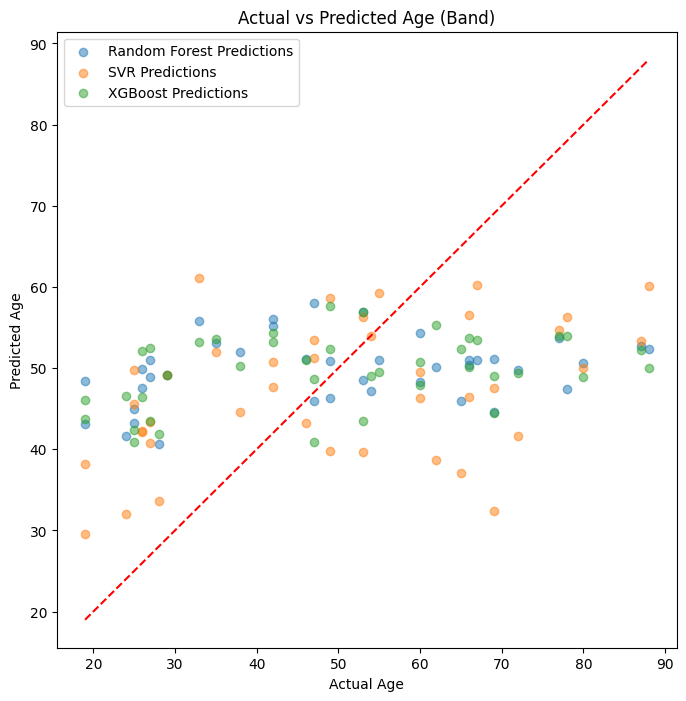

In [37]:
# Visualize the predictions against actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_band, y_pred_rf_band, label='Random Forest Predictions', alpha=0.5)
plt.scatter(y_test_band, y_pred_svr_band, label='SVR Predictions', alpha=0.5)
plt.scatter(y_test_band, y_pred_xgb_band, label='XGBoost Predictions', alpha=0.5)
plt.plot([min(y_test_band), max(y_test_band)], [min(y_test_band), max(y_test_band)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Actual vs Predicted Age (Band)")
plt.legend()
plt.show()